,party,gov_votes,gov_won,gov_mean_vote,gov_counties,governor_vals,pres_votes,pres_won,pres_mean_vote,pres_counties,president_vals
0,Democrat,9001079,80,98.583354,1025,0.000889,82046434.0,1410.0,101.231021,4633.0,0.001719
1,Green,17234,0,99.117714,115,0.000000,407508.0,0.0,101.635887,3034.0,0.000000
2,Independent,6150,0,97.943807,3,0.000000,NaN,NaN,NaN,NaN,NaN
3,Libertarian,581634,0,98.485841,740,0.000000,1874183.0,1.0,101.231021,4633.0,0.000053
4,Other,115460,0,98.762084,2237,0.000000,693232.0,3.0,101.517270,14998.0,0.000433
5,Republican,10698654,945,98.583354,1025,0.008833,74586880.0,3219.0,101.171069,4879.0,0.004316


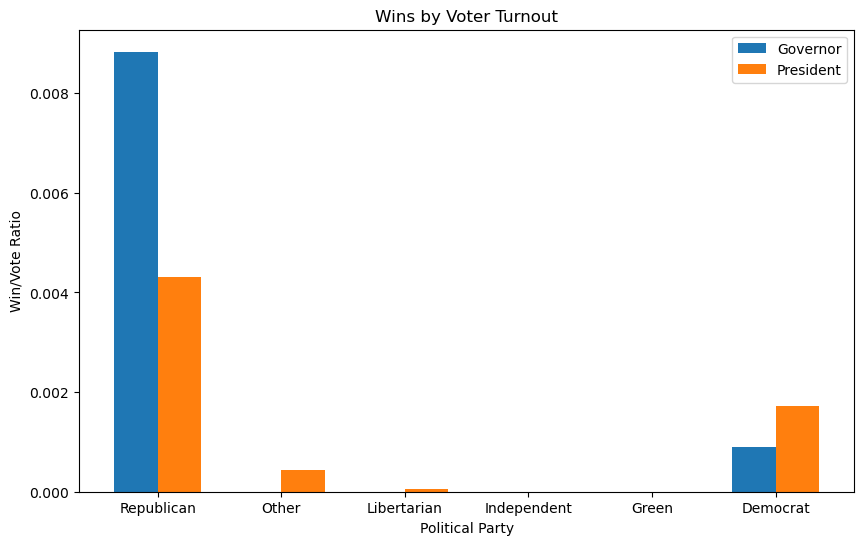

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np 
gcc = pd.read_csv("data/governors_county_candidate.csv")
gc = pd.read_csv("data/governors_county.csv")
pcc = pd.read_csv("data/president_county_candidate.csv")
pc = pd.read_csv("data/president_county.csv")

#aggregating, grouping, merging with Pandas, replacing variable names, sorting
party_map = {"LLC" : "Other", "NON" : "Other", "MNP" : "Other", "TM" : "Other", "DEM" : "Democrat", "REP" : "Republican", "IPD" : "Independent", "LIB" : "Libertarian", "GRN" : "Green", "PRG" : "Other", "ASP" : "Other", "PRO" : "Other", "ALI" : "Other", "APV" : "Other", "UNA" : "Other", "SWP" : "Other", "PSL" : "Other", "IND" : "Other", "CST" : "Other", "WRI" : "Other", "IAP" : "Other", "UTY" : "Other", "SEP" : "Other", "LLP" : "Other", "OTH" : "Other", "GOP" : "Republican", "BAR" : "Other", "BMP" : "Other", "BFP" : "Other"
             }
gc["governor_votes_percentage"] = gc["current_votes"]/gc["total_votes"] * 100
pc["president_votes_percentage"] = pc["current_votes"]/pc["total_votes"] * 100
gcc["party"] = gcc["party"].replace(party_map)
pcc["party"] = pcc["party"].replace(party_map)
pcc = pcc.rename(columns={"total_votes" : "votes"})
all_counties = pd.unique(
    pd.concat([gcc["county"], gc["county"], pcc["county"], pc["county"]]))
county_id_map = pd.Series(data=range(len(all_counties)), index=all_counties)
gc["county_id"] = gc["county"].map(county_id_map)
gcc["county_id"] = gcc["county"].map(county_id_map)
pc["county_id"] = pc["county"].map(county_id_map)
pcc["county_id"] = pcc["county"].map(county_id_map)
governors_agg = (gc.groupby("county_id")
                 .agg(mean_votes = ('governor_votes_percentage', 'mean'),
                      sd_votes = ('governor_votes_percentage', 'std'),
                      min_points = ('governor_votes_percentage', 'min'),
                      max_points = ('governor_votes_percentage', 'max'),
                      appearances = ('governor_votes_percentage', len)))
presidents_agg = (pc.groupby("county_id")
                  .agg(mean_votes = ('president_votes_percentage', 'mean'),
                       sd_votes = ('president_votes_percentage', 'std'),
                       min_votes = ('president_votes_percentage', 'min'),
                       max_votes = ('president_votes_percentage', 'max'),
                       appearances = ('president_votes_percentage', len)))
governors_merge = pd.merge(gcc.sort_values(by = "votes", ascending=False),
                           governors_agg,
                           on = "county_id",
                           how = "left")
presidents_merge = pd.merge(pcc.sort_values(by = "votes", ascending=False),
                            presidents_agg,
                            on = "county_id",
                            how = "left")

#wins by voter turnout grouped by party for governor and presidential elections
governors_party = (governors_merge
                   .groupby("party")[["votes", "won", "mean_votes", "county_id"]]
                   .agg({"votes" : "sum",
                         "won" : "sum",
                         "mean_votes" : "mean",
                         "county_id" : "count"
                         })
                         .reset_index()
                         .sort_values(by="won", ascending=False)
)
presidents_party = (presidents_merge
                    .groupby("party")[["votes", "won", "mean_votes", "county_id"]]
                    .agg({"votes": "sum",
                          "won" : "sum",
                          "mean_votes" : "mean",
                          "county_id" : "count"
                          })
                          .reset_index()
                          .sort_values(by="won", ascending=False)
)
governors_party["governor_vals"] = governors_party["won"]/governors_party["votes"] * 100
presidents_party["president_vals"] = presidents_party["won"]/presidents_party["votes"] * 100
party_compare = pd.merge(
    governors_party.rename(columns={
        "votes" : "gov_votes",
        "won" : "gov_won",
        "mean_votes" : "gov_mean_vote",
        "county_id" : "gov_counties"
    }),
    presidents_party.rename(columns={
        "votes" : "pres_votes",
        "won" : "pres_won",
        "mean_votes" : "pres_mean_vote",
        "county_id" : "pres_counties"
    }),
    on="party",
    how="outer"
)
display(party_compare)

party_plot = party_compare.reset_index().sort_values(by="party", ascending=False)
x = np.arange(len(party_plot["party"]))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, party_plot["governor_vals"], width, label= "orange")
ax.bar(x + width/2, party_plot["president_vals"], width, label = "blue")
ax.set_xlabel("Political Party")
ax.set_xticks(x)
ax.set_xticklabels(party_plot["party"])
ax.set_ylabel("Win/Vote Ratio")
ax.set_title("Wins by Voter Turnout")
legend_labels = ["Governor", "President"]
ax.legend(legend_labels)
plt.show()

Based off county data, Republicans will always have higher ratio than Democrats and third parties because their election strategy relies on winning the majority of counties. In contrast, the Democratic party's election strategy relies more on winning the more few counties with major cities. Moreso in governor elections, Republicans perform better with a higher win/vote ratio than all other parties.

,party,gov_votes,gov_won,gov_mean_vote,gov_counties,governor_vals,pres_votes,pres_won,pres_mean_vote,pres_counties,president_vals,republican_percentage,democrat_percentage,gov_percentage,pres_percentage
0,Democrat,9001079,80,98.583354,1025,0.000889,82046434.0,1410.0,101.231021,4633.0,0.001719,0,0,44.079265,51.404887
1,Green,17234,0,99.117714,115,0.000000,407508.0,0.0,101.635887,3034.0,0.000000,0,0,0.084397,0.255318
2,Independent,6150,0,97.943807,3,0.000000,NaN,NaN,NaN,NaN,NaN,0,0,0.030117,NaN
3,Libertarian,581634,0,98.485841,740,0.000000,1874183.0,1.0,101.231021,4633.0,0.000053,0,0,2.848325,1.174240
4,Other,115460,0,98.762084,2237,0.000000,693232.0,3.0,101.517270,14998.0,0.000433,0,0,0.565420,0.434333
5,Republican,10698654,945,98.583354,1025,0.008833,74586880.0,3219.0,101.171069,4879.0,0.004316,0,0,52.392475,46.731222


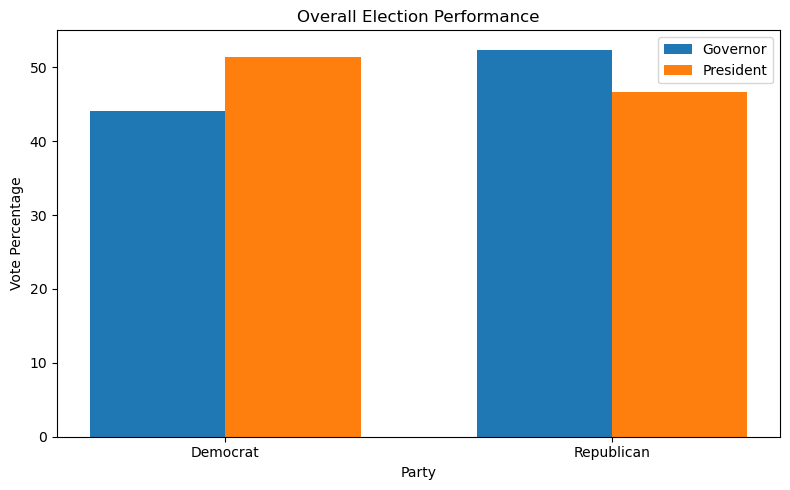

In [154]:
#republican v democrat votes
total_gov_votes = party_compare["gov_votes"].sum()
party_compare["gov_percentage"] = party_compare["gov_votes"] / total_gov_votes * 100
republican_percentage = party_compare.loc[party_compare["party"]=="Republican", "gov_votes"].iloc[0] / total_gov_votes * 100
democrat_percentage = party_compare.loc[party_compare["party"]=="Democrat", "gov_votes"].iloc[0] / total_gov_votes * 100

party_compare["republican_percentage"] = 0
party_compare["democrat_percentage"] = 0
party_compare["gov_percentage"] = party_compare["gov_votes"] / party_compare["gov_votes"].sum() * 100
party_compare["pres_percentage"] = party_compare["pres_votes"] / party_compare["pres_votes"].sum() * 100
rep_dem_gov = party_compare[party_compare["party"].isin(["Republican", "Democrat"])]
rep_dem_pres = party_compare[party_compare["party"].isin(["Republican", "Democrat"])]
display(party_compare)

x = np.arange(len(rep_dem_gov["party"]))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width/2, rep_dem_gov["gov_percentage"], width, label="orange")
ax.bar(x + width/2, rep_dem_pres["pres_percentage"], width, label="blue")
ax.set_xticks(x)
ax.set_xticklabels(rep_dem_gov["party"])
ax.set_xlabel("Party")
ax.set_ylabel("Vote Percentage")
ax.legend(legend_labels)
ax.set_title("Overall Election Performance")
plt.tight_layout()
plt.show()

For governor elections, Republicans perform better in getting more than 50% of votes. For presidential elections, Democrats perform slightly better, getting a bit more than 50% of the vote.